<a href="https://colab.research.google.com/github/PisutSukpool/BADS/blob/main/Technical_Analysis_apply_with_Stock_XD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project นี้ช่วยในการตัดสินใจซื้อ-ขายหุ้น ก่อนและหลัง XD ในช่วงเวลาที่มีโอกาสทำกำไรสูงสุด โดยนำ Technical Analysis ที่ base on indicator ต่างๆ มา apply กับ XD เพื่อหาจุดซื้อขายที่ดีที่สุด

**XD** คืออะไร
https://www.moneybuffalo.in.th/%E0%B8%AB%E0%B8%B8%E0%B9%89%E0%B8%99/xd-%E0%B8%AB%E0%B8%B8%E0%B9%89%E0%B8%99-%E0%B8%84%E0%B8%B7%E0%B8%AD%E0%B8%AD%E0%B8%B0%E0%B9%84%E0%B8%A3

Indicator ที่จะมาช่วยหา Insight เพื่อทำ Decision Making มี 4 วิธี ได้แก่

**1.EMA**
Detail:https://www.finnomena.com/daddy-trader/moving-average/

**2.MACD**
Detail:https://www.finnomena.com/daddy-trader/macd/

**3.RSI**
Detail:https://www.finnomena.com/mrserotonin/what-is-rsi/

**4.Stochastic**
Detail:https://www.thaibrokerforex.com/stochastic-%E0%B8%84%E0%B8%B7%E0%B8%AD%E0%B8%AD%E0%B8%B0%E0%B9%84%E0%B8%A3/


ตัวอย่าง Graph สีเขียวคือจุดซื้อ , สีแดงคือจุดขาย , เส้นตั้งสีดำคือวัน XD

**EMA**

![](https://drive.google.com/uc?export=view&id=1rNdM9NwovZNhO9y-pZ2EPp-bTfXYMNKX)


**MACD**

![](https://drive.google.com/uc?export=view&id=1HCNcgvasIXO-VoyxfoxevzP9wkP-pXTG)

**RSI**

![](https://drive.google.com/uc?export=view&id=1bAKVWPGMM5zVfhVCcRpMygVwEakSw8B3)

**RSI**

![](https://drive.google.com/uc?export=view&id=1bAKVWPGMM5zVfhVCcRpMygVwEakSw8B3)

**Stochastic**

![](https://drive.google.com/uc?export=view&id=1vhwCzxkoeM-2MMKSBA6vbwDU4Xbc4Lp0)

**Start Compare each Indicator**

สร้าง Function Stochastic Indicator

In [8]:
def tn_Stochastic(df):
    n = 14
    slowk_period = 3
    slowd_period = 3
    fastk, fastd = talib.STOCHF(df['High'].values, df['Low'].values, df['Close'].values, fastk_period = n, fastd_period=slowk_period)
    slowk, slowd = talib.STOCH(df['High'].values, df['Low'].values, df['Close'].values, fastk_period = n, slowk_period=slowk_period, slowd_period=slowd_period)
    fk = pd.Series(fastk, index = df.index, name = "STOCHFK_%s_%s_%s" % (str(n), str(slowk_period), str(slowd_period)))
    sk = pd.Series(slowk, index = df.index, name = "STOCHSK_%s_%s_%s" % (str(n), str(slowk_period), str(slowd_period)))
    sd = pd.Series(slowd, index = df.index, name = "STOCHSD_%s_%s_%s" % (str(n), str(slowk_period), str(slowd_period)))
    sto = pd.concat([fk, sk, sd], join='outer', axis=1) 
    signals_sto = pd.DataFrame(index = df.index)
    signals_sto['Date'] = df.index
    signals_sto['Indicator'] = 'Stochastic'
    signals_sto['positions'] = np.nan
    signals_sto['Close'] = df['Close']
    signals_sto['%K'] = sto['STOCHSK_14_3_3']
    signals_sto['%D'] = sto['STOCHSD_14_3_3']
    signals_sto['Sell Entry'] = ((signals_sto['%K'] < signals_sto['%D']) & (signals_sto['%K'].shift(1) > signals_sto['%D'].shift(1))) & (signals_sto['%D'] > 80)
    signals_sto['Buy Entry'] = ((signals_sto['%K'] > signals_sto['%D']) & (signals_sto['%K'].shift(1) < signals_sto['%D'].shift(1))) & (signals_sto['%D'] < 20)
    #Set position to -1 for sell signals
    signals_sto.loc[signals_sto['Sell Entry'],'positions'] = -1 
    #Set position to 1 for buy signals
    signals_sto.loc[signals_sto['Buy Entry'],'positions'] = 1
    signals_sto['Type'] = np.where(signals_sto['positions']==-1,'Sell',np.where(signals_sto['positions']==1,'Buy','')) 
    signals_sto = signals_sto.drop('%K', 1)
    signals_sto = signals_sto.drop('%D', 1)
    signals_sto = signals_sto.drop('Sell Entry', 1)
    signals_sto = signals_sto.drop('Buy Entry', 1)
#     del df['Sell Entry']
#     del df['Buy Entry']    
    return signals_sto  

สร้าง Function RSI Indicator

In [9]:
def tn_RSI(df):
    rsi = talib.RSI(df.Close, timeperiod=14)
    signals_r = pd.DataFrame(data=rsi,columns=['RSI'])
    signals_r['Date'] = df.index
    signals_r['Indicator'] = 'RSI'
    signals_r['signal'] = np.where(signals_r['RSI']<= 30 ,1.0,np.where(signals_r['RSI'] >= 70 ,2.0,0.0))   # 1 is up
    signals_r['positions'] = signals_r['signal'].diff() # 1 is buy position, 2 is sell position  #out[i] = a[i+1] - a[i]
    signals_r['Close'] = df.Close
    signals_r['Type'] = np.where(signals_r['positions']==2,'Sell',np.where(signals_r['positions']==1,'Buy',''))
    signals_r = signals_r.drop('RSI', 1)
    signals_r = signals_r.drop('signal', 1)
    return signals_r  

สร้าง Function MACD Indicator

In [10]:
def tn_MACD(df):
    exp12 = df.Close.ewm(span=12, adjust=False).mean()
    exp26 = df.Close.ewm(span=26, adjust=False).mean()
    macd = exp12-exp26
    exp9 = macd.ewm(span=9, adjust=False).mean()
    price = df['Close']
    #fig = plt.figure(figsize=(15,8))
    #plt.plot(df.index, macd, label='MACD', color = '#EBD2BE')
    #plt.plot(df.index, exp9, label='Signal Line', color='#E5A4CB')
    #plt.legend(loc='upper left')
    
    signals_m = pd.DataFrame(index = df.index)
    signals_m['Date'] = df.index
    signals_m['Indicator'] = 'MACD'
    signals_m['signal'] = 0.0
    signals_m['MACD_Line'] = macd
    signals_m['EMA9_Line'] = exp9
    signals_m['signal'] = np.where(signals_m['MACD_Line']> signals_m['EMA9_Line'],1.0,0.0)   # 1 is up
    #Generate trading orders
    signals_m['positions'] = signals_m['signal'].diff()
    signals_m['Close'] = price
    signals_m['Type'] = np.where(signals_m['positions']==1,'Sell',np.where(signals_m['positions']==-1,'Buy','')) 
    signals_m[:30]
    signals_m = signals_m.drop('MACD_Line', 1)
    signals_m = signals_m.drop('EMA9_Line', 1)
    signals_m = signals_m.drop('signal', 1)
    return signals_m

สร้าง Function Indicator EMA

In [11]:
def tn_ema(df):
    short_window = 10
    long_window = 25
    signals = pd.DataFrame(index = df.index)
    #Short EMA of Short Window
    signals['Date'] = df.index
    signals['Indicator'] = 'EMA'
    signals['short_mavg'] = df['Close'].ewm(span = short_window,adjust=False).mean()
    #Long EMA of Short Window
    signals['long_mavg'] = df['Close'].ewm(span = long_window,adjust=False).mean()
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:],1.0,0.0)
    signals['positions'] = signals['signal'].diff()           #out[i] = a[i+1] - a[i]
    signals['Close']=df.Close
    signals['Type'] =np.where(signals.positions == 1.0,'Buy',np.where(signals.positions == -1.0,'Sell',''))
    signals = signals.drop('short_mavg', 1)
    signals = signals.drop('long_mavg', 1)
    signals = signals.drop('signal', 1)
    return signals

Extract Data From API and import library

Install Library talib

In [12]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

--2021-01-24 17:23:11--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-24 17:23:11--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-24 17:23:12--  https://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving newcon

In [13]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import talib
import copy

st_date = input('Enter Start Date (yyyy/mm/dd): ')
ed_date = input('Enter End Date (yyyy/mm/dd): ')
stock_name = input('What stock do you find? : ').upper()

start = datetime.date(year=int(st_date[:4]),month=int(st_date[5:7]),day=int(st_date[8:]))
end =   datetime.date(year=int(ed_date[:4]),month=int(ed_date[5:7]),day=int(ed_date[8:]))

df = web.DataReader(stock_name+'.BK', 'yahoo', start, end) #"ADVANC.BK"
xd=web.DataReader(stock_name+'.BK','yahoo-actions', start, end)

Enter Start Date (yyyy/mm/dd): 2012/01/01
Enter End Date (yyyy/mm/dd): 2020/12/31
What stock do you find? : ADVANC


run check data

In [14]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-04,147.0,143.5,143.5,146.5,8904300.0,96.307686
2012-01-05,148.0,145.5,148.0,146.0,3042300.0,95.979004
2012-01-06,145.5,143.5,145.0,143.5,3873400.0,94.335518
2012-01-09,148.0,143.5,143.5,148.0,3049600.0,97.293777
2012-01-10,154.5,149.0,149.5,154.0,5298500.0,101.238113
...,...,...,...,...,...,...
2020-12-24,179.5,176.5,177.5,178.5,7358400.0,178.500000
2020-12-25,180.0,178.5,179.0,179.0,5196700.0,179.000000
2020-12-28,180.0,176.5,180.0,177.0,7816100.0,177.000000


Transfer XD to List of Tuple

In [15]:
old_xd=[]
both=[]
xd['Date']=xd.index
for i,row_xd in xd.iterrows():
    both.append(row_xd['Date'])
    both.append(row_xd['value'])
    both_tp=tuple(both)
    old_xd.append(copy.deepcopy(both_tp))
    del both[:]
xd
old_xd.sort()
old_xd

[(Timestamp('2012-04-02 00:00:00'), 4.26),
 (Timestamp('2012-08-21 00:00:00'), 5.9),
 (Timestamp('2013-04-01 00:00:00'), 5.0),
 (Timestamp('2013-08-16 00:00:00'), 6.4),
 (Timestamp('2014-03-28 00:00:00'), 5.75),
 (Timestamp('2014-08-13 00:00:00'), 6.04),
 (Timestamp('2015-03-26 00:00:00'), 5.96),
 (Timestamp('2015-08-11 00:00:00'), 6.5),
 (Timestamp('2016-03-31 00:00:00'), 6.49),
 (Timestamp('2016-08-15 00:00:00'), 5.79),
 (Timestamp('2017-04-05 00:00:00'), 4.29),
 (Timestamp('2017-08-07 00:00:00'), 3.51),
 (Timestamp('2018-04-05 00:00:00'), 3.57),
 (Timestamp('2018-08-15 00:00:00'), 3.78),
 (Timestamp('2019-02-20 00:00:00'), 3.3),
 (Timestamp('2019-08-16 00:00:00'), 3.78),
 (Timestamp('2020-02-19 00:00:00'), 3.56),
 (Timestamp('2020-08-19 00:00:00'), 3.24)]

Find maximum different price between XD date

In [16]:
ls_xd=[]
max_diff=0
min_diff=0
for a in range(len(old_xd)):
    if a==0:
        e=list(old_xd[0])
        e.append('')
        tp_e=tuple(e)
        ls_xd.append(tp_e)
    else:
        for ind,row_m in df.iterrows():
            if ind>old_xd[a-1][0] and ind<old_xd[a][0]: #date between xd1 -> xd2
                if max_diff==0 and min_diff==0:
                    max_diff+=row_m['Close']
                    min_diff+=row_m['Close']
                if row_m['Close']>max_diff:
                    max_diff=0
                    max_diff+=row_m['Close']
                if row_m['Close']<min_diff: 
                    min_diff=0
                    min_diff+=row_m['Close']
        diff = max_diff-min_diff
        t=list(old_xd[a])
        t.append(diff)
        tup=tuple(t)
        ls_xd.append(tup)
    max_diff=0
    min_diff=0    
            
ls_xd     

[(Timestamp('2012-04-02 00:00:00'), 4.26, ''),
 (Timestamp('2012-08-21 00:00:00'), 5.9, 45.0),
 (Timestamp('2013-04-01 00:00:00'), 5.0, 59.0),
 (Timestamp('2013-08-16 00:00:00'), 6.4, 84.0),
 (Timestamp('2014-03-28 00:00:00'), 5.75, 91.0),
 (Timestamp('2014-08-13 00:00:00'), 6.04, 43.0),
 (Timestamp('2015-03-26 00:00:00'), 5.96, 49.0),
 (Timestamp('2015-08-11 00:00:00'), 6.5, 22.0),
 (Timestamp('2016-03-31 00:00:00'), 6.49, 110.0),
 (Timestamp('2016-08-15 00:00:00'), 5.79, 39.5),
 (Timestamp('2017-04-05 00:00:00'), 4.29, 38.5),
 (Timestamp('2017-08-07 00:00:00'), 3.51, 20.0),
 (Timestamp('2018-04-05 00:00:00'), 3.57, 37.5),
 (Timestamp('2018-08-15 00:00:00'), 3.78, 24.0),
 (Timestamp('2019-02-20 00:00:00'), 3.3, 37.5),
 (Timestamp('2019-08-16 00:00:00'), 3.78, 46.0),
 (Timestamp('2020-02-19 00:00:00'), 3.56, 41.5),
 (Timestamp('2020-08-19 00:00:00'), 3.24, 39.5)]

Combine Method and Choose Sell,Buy record

In [17]:
df_m=tn_MACD(df)
df_r=tn_RSI(df)
df_s=tn_Stochastic(df)
df_e=tn_ema(df)
df_slice=pd.concat([df_m,df_r,df_s,df_e],ignore_index=True).drop_duplicates().reset_index(drop=True)
df_sort=df_slice.sort_values(by=['Date','Indicator'])
df_info=df_sort.reset_index(drop=True)
df_main = df_info[df_info['Type'] != '']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [18]:
ls_each=[]
ls_stock=[]


for i in range(len(ls_xd)):
    try:
        mask = (df_main['Date'] > ls_xd[i][0]) & (df_main['Date'] <= ls_xd[i+1][0]) #date between xd1 -> xd2
        df_test = df_main.loc[mask].sort_values(by = 'Date')
        df_test.index = range(len(df_test))
        for b, row_b in df_test.iterrows():
            if row_b['Type']=='Buy':
                for s,row_s in df_test.iloc[b:,].iterrows():        
                    if  row_s['Type']=='Sell':
                        diff=row_s['Close']-row_b['Close']
                        ls_each.append(ls_xd[i][0]) #xd_start
                        ls_each.append(ls_xd[i+1][0]) #xd_end
                        ls_each.append(ls_xd[i+1][1])  #xd_value
                        ls_each.append(row_b['Indicator'])
                        ls_each.append(row_s['Indicator'])
                        ls_each.append(row_b['Date'])
                        ls_each.append(row_s['Date'])
                        ls_each.append(row_b['Close'])
                        ls_each.append(row_s['Close'])
                        ls_each.append(diff)
                        ls_each.append(ls_xd[i+1][2]) #best_diff
                        tp_each=tuple(ls_each)
                        ls_stock.append(copy.deepcopy(tp_each))
                        del ls_each[:] 
    except IndexError:
        pass

In [19]:
stock_form = pd.DataFrame(ls_stock, columns=['XD_Start','XD_End','Value','Buy_Indicator','Sell_Indicator','Buy_Date','Sell_Date','Buy_Price','Sell_Price','Diff','Max_Div'])
#stock_form['Efficiency']=(stock_form['Diff']/(max_div(df_main)))*100
stock_form['Better'] = stock_form['Diff']-stock_form['Value']
stock_form['Efficiency']=(stock_form['Diff']/stock_form['Max_Div'])*100  

In [20]:
stock_form

,XD_Start,XD_End,Value,Buy_Indicator,Sell_Indicator,Buy_Date,Sell_Date,Buy_Price,Sell_Price,Diff,Max_Div,Better,Efficiency
0,2012-04-02,2012-08-21,5.90,MACD,EMA,2012-04-04,2012-04-19,181.5,169.5,-12.0,45.0,-17.90,-26.666667
1,2012-04-02,2012-08-21,5.90,MACD,MACD,2012-04-04,2012-04-26,181.5,183.0,1.5,45.0,-4.40,3.333333
2,2012-04-02,2012-08-21,5.90,MACD,Stochastic,2012-04-04,2012-05-03,181.5,181.5,0.0,45.0,-5.90,0.000000
3,2012-04-02,2012-08-21,5.90,MACD,Stochastic,2012-04-04,2012-05-10,181.5,182.0,0.5,45.0,-5.40,1.111111
4,2012-04-02,2012-08-21,5.90,MACD,MACD,2012-04-04,2012-05-17,181.5,187.5,6.0,45.0,0.10,13.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,2020-02-19,2020-08-19,3.24,MACD,MACD,2020-07-24,2020-08-06,185.0,190.0,5.0,39.5,1.76,12.658228
2206,2020-02-19,2020-08-19,3.24,MACD,Stochastic,2020-07-24,2020-08-14,185.0,191.5,6.5,39.5,3.26,16.455696
2207,2020-02-19,2020-08-19,3.24,Stochastic,MACD,2020-07-31,2020-08-06,185.0,190.0,5.0,39.5,1.76,12.658228
2208,2020-02-19,2020-08-19,3.24,Stochastic,Stochastic,2020-07-31,2020-08-14,185.0,191.5,6.5,39.5,3.26,16.455696


In [21]:
stock_form.nlargest(5, ['Efficiency'])

,XD_Start,XD_End,Value,Buy_Indicator,Sell_Indicator,Buy_Date,Sell_Date,Buy_Price,Sell_Price,Diff,Max_Div,Better,Efficiency
1669,2017-08-07,2018-04-05,3.57,RSI,RSI,2017-11-23,2018-03-26,175.0,212.0,37.0,37.5,33.43,98.666667
1266,2016-03-31,2016-08-15,5.79,Stochastic,MACD,2016-05-16,2016-08-08,146.5,185.0,38.5,39.5,32.71,97.468354
1267,2016-03-31,2016-08-15,5.79,Stochastic,RSI,2016-05-16,2016-08-08,146.5,185.0,38.5,39.5,32.71,97.468354
1501,2016-08-15,2017-04-05,4.29,Stochastic,Stochastic,2016-11-22,2017-03-30,142.0,179.5,37.5,38.5,33.21,97.402597
1513,2016-08-15,2017-04-05,4.29,RSI,Stochastic,2016-12-02,2017-03-30,142.0,179.5,37.5,38.5,33.21,97.402597


ิVisualize the appropriate indicator for each stock

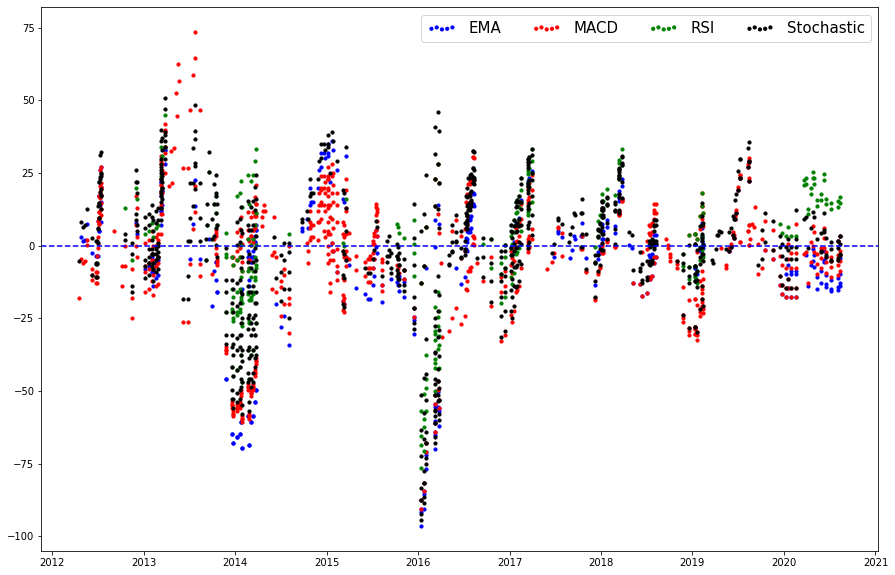

In [33]:
sc_ema=stock_form[stock_form.Buy_Indicator == 'EMA']
sc_macd=stock_form[stock_form.Buy_Indicator == 'MACD']
sc_rsi=stock_form[stock_form.Buy_Indicator == 'RSI']
sc_sto=stock_form[stock_form.Buy_Indicator == 'Stochastic']

plt.figure(figsize=(15,10))
le_ema = plt.scatter(sc_ema['Sell_Date'] , sc_ema['Better'] , s =10, c = 'blue')
le_macd = plt.scatter(sc_macd['Sell_Date'] , sc_macd['Better'] , s =10, c = 'red')
le_rsi = plt.scatter(sc_rsi['Sell_Date'] , sc_rsi['Better'] , s =10, c = 'green')
le_sto = plt.scatter(sc_sto['Sell_Date'] , sc_sto['Better'] , s =10, c = 'black')
plt.axhline(y=0, color='b', linestyle='--')
plt.legend((le_ema, le_macd, le_rsi, le_sto),
           ('EMA', 'MACD', 'RSI', 'Stochastic'),
           scatterpoints=5,
           loc='upper right',
           ncol=4,
           fontsize=15)
plt.show()

Diff = ผลตอบแทนจากการ ซื้อขายโดยใช้ technical ของ indicator ข้างต้น

Value = ผลตอบแทนจากการปันผลวัน XD Date

Better = Diff - Value ถ้าติดลบแสดงว่ารอปันผลดีกว่าใช้ technical ถ้าเป็นบวกแสดงว่าใช้ technical ดีกว่ารอปันผล    

จากการเส้นประที่ Better = 0

ถ้า Better อยู่เหนือบนเส้นประ แสดงว่าหุ้นตัวนี้ใช้ technical ได้ผล แต่ต้องมาดูอีกว่าหุ้นตัวนี้เหมาะกับ indicator ใดโดยดูจากกลุ่มสีของ scatter plot 